# Cell 1: Imports and Setup

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D # For custom legend handles
from datetime import date # For type hinting if using dates
import logging

import pandas as pd
pd.set_option('display.max_columns', None)


# Configure logging (set level, format, etc.) - Basic example
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True) # force=True might be needed in notebooks

# Add functions directory to path to import custom modules
# Assuming the notebook is run from the project root directory
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

import importlib
# Import the data fetching and loading functions
from functions.data_fetching.earthquake_data import fetch_and_load_earthquake_data
from functions.data_fetching.plate_data import load_plate_boundaries
from functions.data_fetching.natural_earth_downloader import load_natural_earth_data
import functions.data_processing
# Import the plotting function
import functions.plotting

logging.info("Libraries and custom functions imported.")

2025-04-08 12:01:00,812 - INFO - Libraries and custom functions imported.


# Cell 2: Define Parameters

In [2]:
# Define the minimum magnitude for earthquake data
min_eq_magnitude = 1.0

# Define target CRS (used by loading functions by default)
target_crs_epsg = "EPSG:4326"

# Define date range (optional, defaults in function are ~last year)
# Set to None if not using specific dates, otherwise define as string or date object
start_date = "2020-01-01" # Example: "2024-01-01" or date(2024, 1, 1)
end_date =  "2024-12-31"   # Example: "2024-12-31" or date(2024, 12, 31)

# Cell 3: Load Data using Functions

In [3]:
# Load Earthquake Data
logging.info(f"Loading earthquake data (min magnitude: {min_eq_magnitude}, target CRS: {target_crs_epsg})...")
earthquake_gdf = fetch_and_load_earthquake_data(
    min_magnitude=min_eq_magnitude,
    target_crs=target_crs_epsg,
    start_date=start_date, # Pass defined start_date
    end_date=end_date      # Pass defined end_date
)
# drop columns we don't need
earthquake_gdf.drop(columns=['tz', 'url', 'detail','title', 'updated','sources','ids','types'], inplace=True)
if earthquake_gdf is not None:
    logging.info(f"-> Successfully loaded {len(earthquake_gdf)} earthquakes. CRS: {earthquake_gdf.crs}")
else:
    logging.error("-> Failed to load earthquake data.")

# Load Plate Boundary Data
logging.info(f"\nLoading tectonic plate boundary data (target CRS: {target_crs_epsg})...")
plate_gdf = load_plate_boundaries(target_crs=target_crs_epsg)
if plate_gdf is not None:
    logging.info(f"-> Successfully loaded {len(plate_gdf)} plate boundary features. CRS: {plate_gdf.crs}")
else:
    logging.error("-> Failed to load plate boundary data.")

# Load Natural Earth Data
logging.info(f"\nLoading Natural Earth 50m countries and 10m lakes data (target CRS: {target_crs_epsg})...")
natural_earth_data = load_natural_earth_data(target_crs=target_crs_epsg)
ne_countries_gdf = natural_earth_data.get('countries') # Changed key and variable name
ne_lakes_gdf = natural_earth_data.get('lakes')

if ne_countries_gdf is not None:
    logging.info(f"-> Successfully loaded {len(ne_countries_gdf)} countries. CRS: {ne_countries_gdf.crs}")
else:
    logging.error("-> Failed to load Natural Earth countries.")

if ne_lakes_gdf is not None:
    logging.info(f"-> Successfully loaded {len(ne_lakes_gdf)} lakes. CRS: {ne_lakes_gdf.crs}")
else:
    logging.error("-> Failed to load Natural Earth lakes.")

2025-04-08 12:01:01,113 - INFO - Loading earthquake data (min magnitude: 1.0, target CRS: EPSG:4326)...
2025-04-08 12:01:01,114 - INFO - Processing earthquake data from 2020-01-01 to 2024-12-31 (inclusive)...
2025-04-08 12:01:01,215 - INFO - All daily files already exist locally.
2025-04-08 12:01:01,216 - INFO - Loading daily GeoJSON files...
2025-04-08 12:02:32,405 - INFO - Concatenating data from 1827 daily files...
c:\Users\Hannah Miller Young\OneDrive\Documents\GE3250 Computational Geoscience\hannah_miller_term_project\functions\data_fetching\earthquake_data.py:219: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_gdf = pd.concat(daily_gdfs, ignore_index=True)
2025-04-08 12:02:33,983 - INFO - Successfully loaded and combined 55278

# Cell 4: Check Loaded Data

In [4]:
# Verify if essential data for plotting was loaded successfully
can_plot_plates_eq = all(gdf is not None for gdf in [plate_gdf, earthquake_gdf])
can_plot_ne = all(gdf is not None for gdf in [ne_countries_gdf, ne_lakes_gdf]) # Basemap is optional, updated variable

if not can_plot_plates_eq:
    logging.error("Error: Cannot proceed with plotting as Plate Boundary or Earthquake data failed to load.")
else:
    logging.info("Essential data (Plates, Earthquakes) loaded successfully.")
    if not can_plot_ne:
        logging.warning("Warning: Natural Earth basemap data failed to load. Plot will be generated without basemap.")
    else:
        logging.info("Natural Earth basemap data loaded successfully.")

2025-04-08 12:02:37,940 - INFO - Essential data (Plates, Earthquakes) loaded successfully.
2025-04-08 12:02:37,940 - INFO - Natural Earth basemap data loaded successfully.


# Calculate the UTM Zone for every earthquak point, project the point to that utm zone in a new column

In [ ]:
import pandas as pd # Added for pd.isna
from shapely.geometry import Point
import geopandas as gpd
import math
import swifter # Import swifter
import logging # Make sure logging is configured elsewhere

from functions import data_processing



# Make our earthquake location with a depth a 2d point. be efficient for testing and only do this if we haven't done it before
if not earthquake_gdf.empty and 'geometry' in earthquake_gdf.columns and earthquake_gdf['geometry'].iloc[0] is not None and hasattr(earthquake_gdf['geometry'].iloc[0], 'has_z') and earthquake_gdf['geometry'].iloc[0].has_z:
    logging.info("earthquake_gdf geometry is 3D. Converting to 2D.")
    # Ensure we only apply to actual geometry objects, handle None
    earthquake_gdf['geometry'] = earthquake_gdf['geometry'].swifter.apply(
        lambda geom: Point(geom.x, geom.y) if geom and hasattr(geom, 'x') else None
    )
else:
    logging.info("earthquake_gdf geometry is not 3D or conversion not needed. Skipping conversion.")

# --- Modified Apply Call ---
logging.info("Calculating UTM info and reprojecting geometry using swifter...")

# Apply the combined function row-wise using swifter
# Pass the source_crs as an argument

earthquake_with_utm_gdf = earthquake_gdf.query(f'mag>5').copy()
result_series = earthquake_with_utm_gdf.swifter.apply(
    data_processing.get_utm_info_and_reproject,
    source_crs=earthquake_with_utm_gdf.crs, # Pass the source CRS here
    axis=1
)
earthquake_with_utm_gdf[['utm_zone', 'utm_epsg', 'utm_geometry']] = gpd.GeoDataFrame(
    result_series.tolist(),
    index=earthquake_with_utm_gdf.index
)
earthquake_with_utm_gdf.head()

2025-04-08 12:05:37,166 - INFO - earthquake_gdf geometry is not 3D or conversion not needed. Skipping conversion.
2025-04-08 12:05:37,171 - INFO - Calculating UTM info and reprojecting geometry using swifter...


Pandas Apply:   0%|          | 0/6467 [00:00<?, ?it/s]

,id,mag,place,time,felt,cdi,mmi,alert,status,tsunami,sig,net,code,nst,dmin,rms,gap,magType,type,geometry,source_date,utm_zone,utm_epsg,utm_geometry
104,us70006t8d,5.4,south of the Kermadec Islands,1577906930580,NaN,NaN,0.00,green,reviewed,0,449,us,70006t8d,NaN,3.721,0.97,49.0,mww,earthquake,POINT (-178.3339 -32.9622),2020-01-01,1S,EPSG:32701,POINT (375334.88132682873 6352113.912391372)
127,us70006t7e,5.1,"Near Islands, Aleutian Islands, Alaska",1577902211727,NaN,NaN,NaN,None,reviewed,1,400,us,70006t7e,NaN,2.323,0.63,78.0,mww,earthquake,POINT (170.3548 53.2522),2020-01-01,59N,EPSG:32659,POINT (456953.3782219746 5900520.50625118)
332,us70006t3c,5.4,"207 km NE of Neiafu, Tonga",1577867484136,NaN,NaN,0.00,green,reviewed,0,449,us,70006t3c,NaN,2.947,1.44,40.0,mww,earthquake,POINT (-172.5044 -17.428),2020-01-01,2S,EPSG:32702,POINT (340219.5454896431 8072468.101835433)
499,us70006t13,5.1,"112 km SSE of Kokopo, Papua New Guinea",1577838500289,NaN,NaN,NaN,None,reviewed,0,400,us,70006t13,NaN,1.190,0.79,74.0,mb,earthquake,POINT (152.5514 -5.3245),2020-01-01,56S,EPSG:32756,POINT (450295.50700925535 9411447.729474423)
624,us70006ttf,5.7,"38 km ENE of Hasaki, Japan",1577989433135,102.0,4.7,4.11,green,reviewed,0,548,us,70006ttf,NaN,0.912,1.03,61.0,mww,earthquake,POINT (141.249 35.8098),2020-01-02,54N,EPSG:32654,POINT (522495.56476408505 3962881.4285291713)


In [8]:
import geopandas as gpd
from functions.spatial_analysis import calculate_distance_to_plate

earthquake_gdf_with_distances = gpd.GeoDataFrame(calculate_distance_to_plate(earthquake_with_utm_gdf, plate_gdf, max_workers=4, log_level='NONE'))

earthquake_gdf_with_distances.head()

2025-04-08 12:07:01,719 - INFO - --- Finished calculate_distance_to_plate ---


,id,mag,place,time,felt,cdi,mmi,alert,status,tsunami,sig,net,code,nst,dmin,rms,gap,magType,type,geometry,source_date,utm_zone,utm_epsg,utm_geometry,distance_to_plate,nearest_plate_strnum,nearest_plate_platecode,nearest_plate_geogdesc,nearest_plate_boundary_t
104,us70006t8d,5.4,south of the Kermadec Islands,1577906930580,NaN,NaN,0.00,green,reviewed,0,449,us,70006t8d,NaN,3.721,0.97,49.0,mww,earthquake,POINT (-178.3339 -32.9622),2020-01-01,1S,EPSG:32701,POINT (375334.88133 6352113.91239),NaN,<NA>,<NA>,<NA>,<NA>
127,us70006t7e,5.1,"Near Islands, Aleutian Islands, Alaska",1577902211727,NaN,NaN,NaN,None,reviewed,1,400,us,70006t7e,NaN,2.323,0.63,78.0,mww,earthquake,POINT (170.3548 53.2522),2020-01-01,59N,EPSG:32659,POINT (456953.37822 5900520.50625),9.045895e+05,2,201,SOUTH ATLANTIC RIDGE,ridge
332,us70006t3c,5.4,"207 km NE of Neiafu, Tonga",1577867484136,NaN,NaN,0.00,green,reviewed,0,449,us,70006t3c,NaN,2.947,1.44,40.0,mww,earthquake,POINT (-172.5044 -17.428),2020-01-01,2S,EPSG:32702,POINT (340219.54549 8072468.10184),NaN,<NA>,<NA>,<NA>,<NA>
499,us70006t13,5.1,"112 km SSE of Kokopo, Papua New Guinea",1577838500289,NaN,NaN,NaN,None,reviewed,0,400,us,70006t13,NaN,1.190,0.79,74.0,mb,earthquake,POINT (152.5514 -5.3245),2020-01-01,56S,EPSG:32756,POINT (450295.50701 9411447.72947),1.766909e+05,2,201,SOUTH ATLANTIC RIDGE,ridge
624,us70006ttf,5.7,"38 km ENE of Hasaki, Japan",1577989433135,102.0,4.7,4.11,green,reviewed,0,548,us,70006ttf,NaN,0.912,1.03,61.0,mww,earthquake,POINT (141.249 35.8098),2020-01-02,54N,EPSG:32654,POINT (522495.56476 3962881.42853),1.599986e+06,2,201,SOUTH ATLANTIC RIDGE,ridge


2025-04-08 12:07:02,028 - INFO - 
Generating plot...
2025-04-08 12:07:02,105 - INFO - Plotting Natural Earth layers...
2025-04-08 12:07:02,108 - INFO - Plotting land boundaries...
2025-04-08 12:07:03,675 - INFO - Filtering lakes to top 100 by area (using original CRS area)...
2025-04-08 12:07:03,675 - INFO - Original lake CRS (WGS 84) is geographic.
2025-04-08 12:07:03,675 - INFO - Direct area calculation (degrees-squared) is unsuitable for size comparison.
2025-04-08 12:07:03,687 - INFO - Attempting temporary reprojection to EPSG:3857 (Web Mercator) for approximate area calculation.
2025-04-08 12:07:03,746 - INFO - Successfully reprojected temporarily to very roughly approximate area for ranking purposes only.
2025-04-08 12:07:03,752 - INFO - Plotting 100 largest lakes.
2025-04-08 12:07:04,058 - INFO - Plotting plate boundaries by type...
2025-04-08 12:07:04,640 - INFO - Plotted boundary types found: ['ridge' 'transform' 'trench']
2025-04-08 12:07:04,640 - INFO - Plotting earthquake d

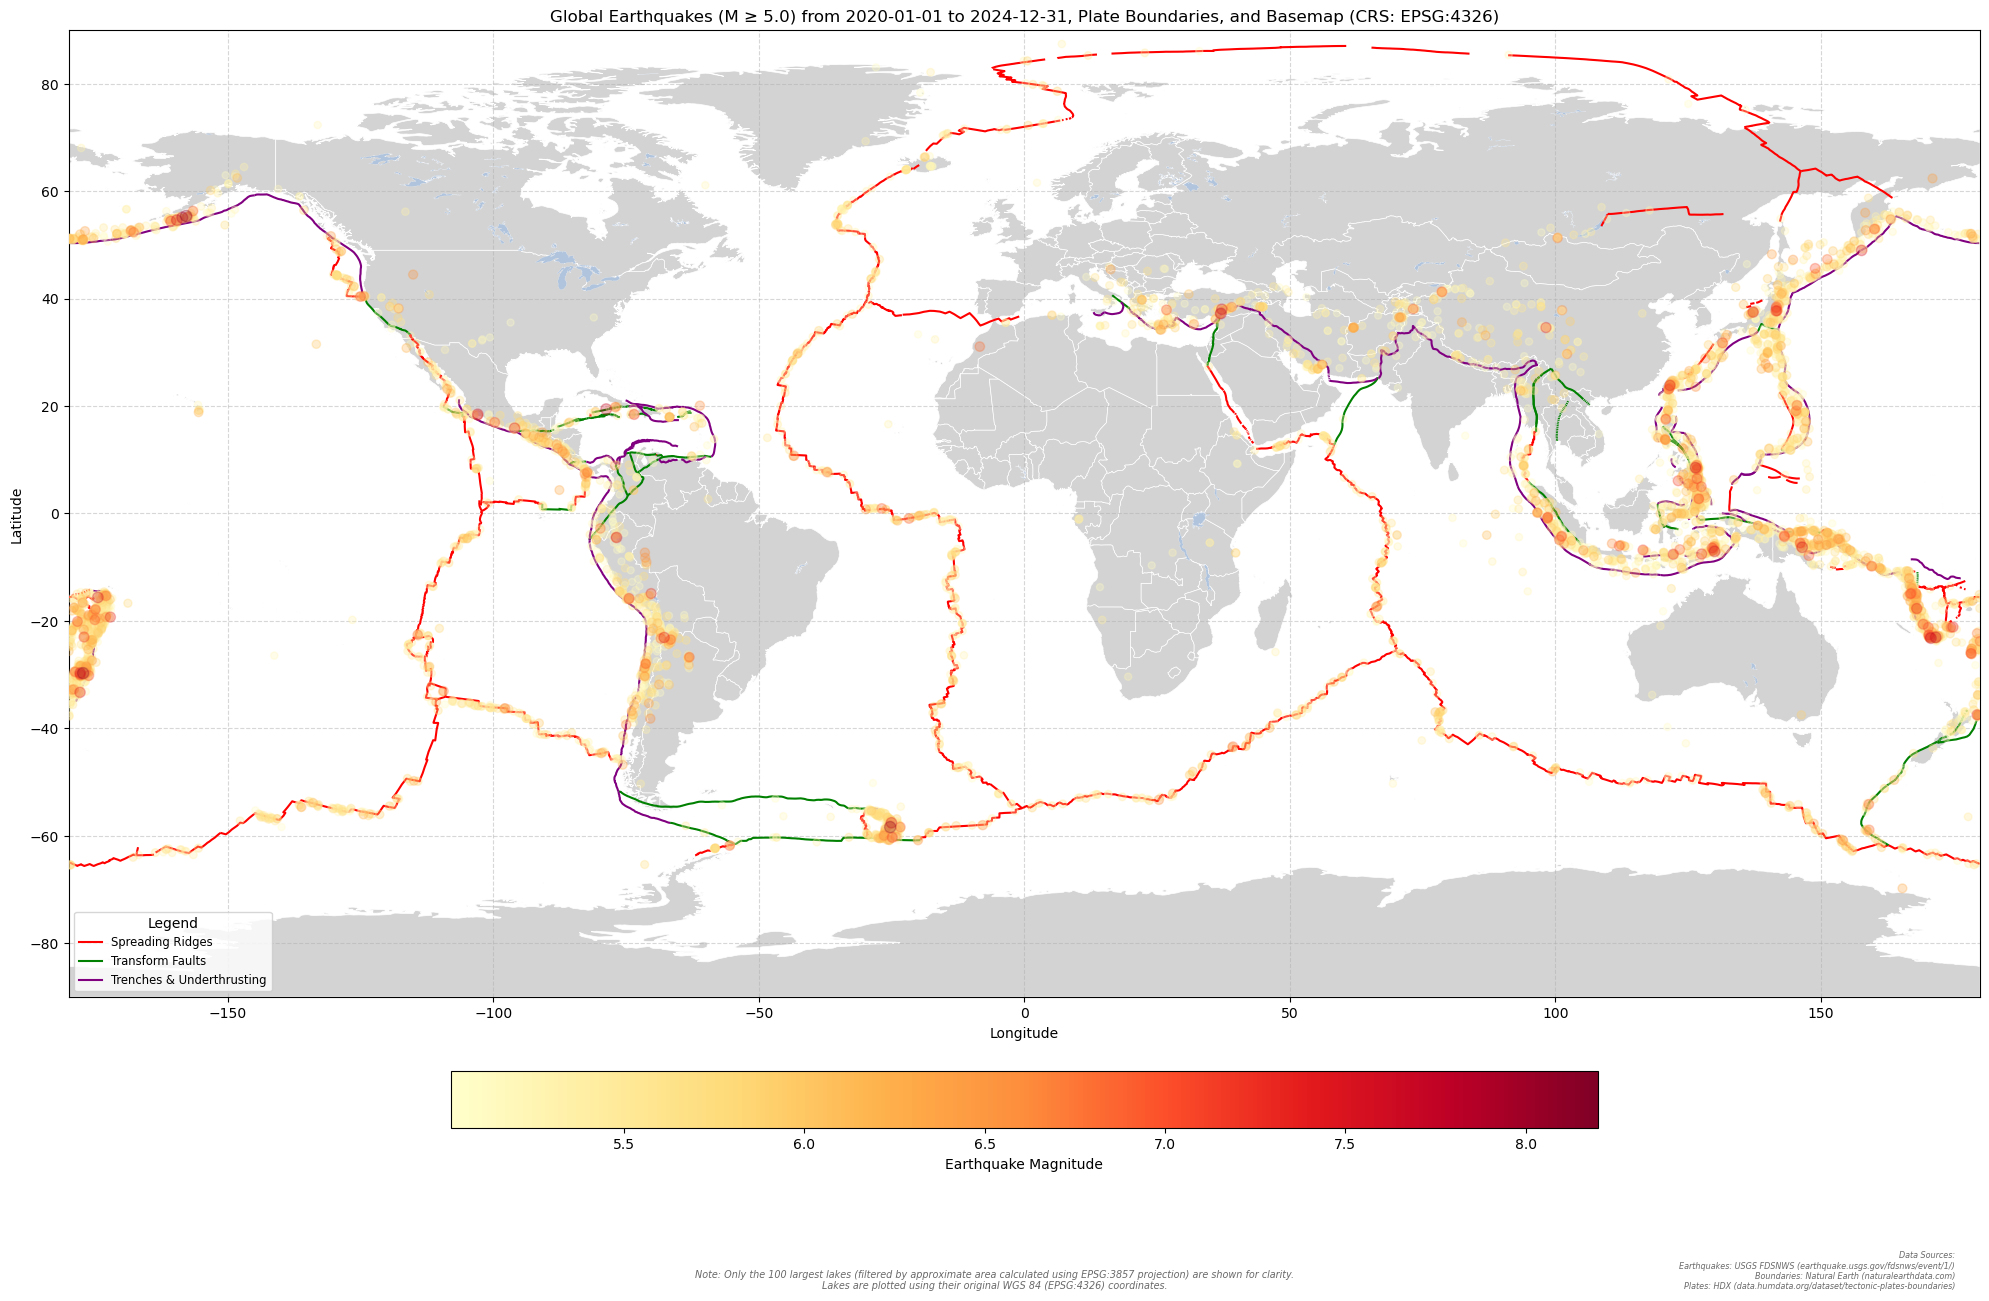

2025-04-08 12:07:07,145 - INFO - Plot displayed.


In [9]:
if can_plot_plates_eq:
    functions.plotting.plot_earthquake_plate_map( # Ensure using the reloaded module
        earthquake_gdf=earthquake_gdf_with_distances,
        plate_gdf=plate_gdf,
        ne_land_gdf=ne_countries_gdf, # Pass countries to the renamed parameter
        ne_lakes_gdf=ne_lakes_gdf,
        min_magnitude=min_eq_magnitude,
        start_date=start_date, # Pass the defined start_date (could be None)
        end_date=end_date,     # Pass the defined end_date (could be None)
        target_crs_epsg=target_crs_epsg
    )
else:
    logging.warning("Skipping plot generation due to data loading errors.")

In [10]:
earthquake_gdf_with_distances.query('distance_to_plate>0').head()

,id,mag,place,time,felt,cdi,mmi,alert,status,tsunami,sig,net,code,nst,dmin,rms,gap,magType,type,geometry,source_date,utm_zone,utm_epsg,utm_geometry,distance_to_plate,nearest_plate_strnum,nearest_plate_platecode,nearest_plate_geogdesc,nearest_plate_boundary_t
127,us70006t7e,5.1,"Near Islands, Aleutian Islands, Alaska",1577902211727,NaN,NaN,NaN,None,reviewed,1,400,us,70006t7e,NaN,2.323,0.63,78.0,mww,earthquake,POINT (170.3548 53.2522),2020-01-01,59N,EPSG:32659,POINT (456953.37822 5900520.50625),9.045895e+05,2,201,SOUTH ATLANTIC RIDGE,ridge
499,us70006t13,5.1,"112 km SSE of Kokopo, Papua New Guinea",1577838500289,NaN,NaN,NaN,None,reviewed,0,400,us,70006t13,NaN,1.190,0.79,74.0,mb,earthquake,POINT (152.5514 -5.3245),2020-01-01,56S,EPSG:32756,POINT (450295.50701 9411447.72947),1.766909e+05,2,201,SOUTH ATLANTIC RIDGE,ridge
624,us70006ttf,5.7,"38 km ENE of Hasaki, Japan",1577989433135,102.0,4.7,4.110,green,reviewed,0,548,us,70006ttf,NaN,0.912,1.03,61.0,mww,earthquake,POINT (141.249 35.8098),2020-01-02,54N,EPSG:32654,POINT (522495.56476 3962881.42853),1.599986e+06,2,201,SOUTH ATLANTIC RIDGE,ridge
691,us70006tjm,5.2,"22 km E of Malango, Solomon Islands",1577972488449,9.0,3.8,5.530,green,reviewed,0,419,us,70006tjm,NaN,9.131,0.83,79.0,mww,earthquake,POINT (159.9214 -9.6778),2020-01-02,57S,EPSG:32757,POINT (601083.33149 8930074.09113),3.405611e+05,2,201,SOUTH ATLANTIC RIDGE,ridge
889,us70006tev,5.5,"81 km SW of T?yb?d, Iran",1577939346582,6.0,4.8,6.842,green,reviewed,0,468,us,70006tev,NaN,1.655,0.91,45.0,mww,earthquake,POINT (60.2681 34.1326),2020-01-02,41N,EPSG:32641,POINT (248072.00973 3780230.14212),2.375902e+06,33,501,"CARLSBERG RIDGE, NORTHWEST INDIAN OCEAN",ridge


In [11]:
# Preview the plate ridgeds in order of activity
earthquake_gdf_with_distances.groupby('nearest_plate_geogdesc').size().reset_index(name='count').sort_values('count', ascending=False)

,nearest_plate_geogdesc,count
24,SOUTH ATLANTIC RIDGE,1934
3,"CARLSBERG RIDGE, NORTHWEST INDIAN OCEAN",290
20,PHILIPPINE TRENCH,265
26,SS FAULT THROUGH N. SULAWESI (PALU FAULT),243
27,SUMATRA FAULT (RIGHT-LATERAL S. SUMATRA),194
18,PHILIPPINE FAULT,186
15,PACIFIC-NAZCA SPREADING CENTER,185
23,SOUTH AMERICAN TRENCH,176
7,JAVA TRENCH (ACTIVE SUBDUCTION) (C. PART FROM SU,142
2,"BOCONO TRANSFORM FAULT, N. SOUTH AMERICA",91


# Distance From Ridge and Magnitude Analysis and Exploration

In [12]:
# counts by ridge type
earthquake_gdf_with_distances.groupby('nearest_plate_boundary_t').size().reset_index(name='count').sort_values('count', ascending=False)

,nearest_plate_boundary_t,count
0,ridge,2554
2,trench,1032
1,transform,824


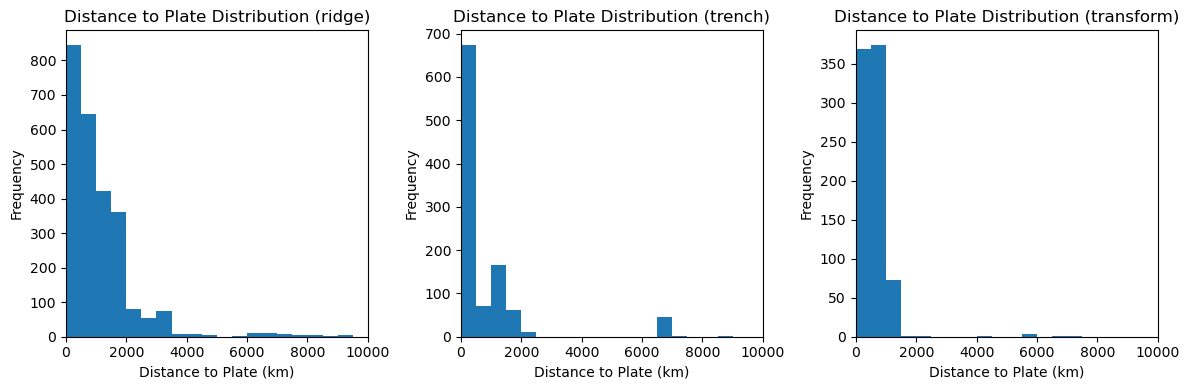

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming earthquake_gdf_with_distances is your DataFrame

# Convert distance to kilometers
earthquake_gdf_with_distances['distance_to_plate_km'] = earthquake_gdf_with_distances['distance_to_plate'] / 1000

# Get unique boundary types, excluding those where *all* distances are NaN
unique_boundaries = earthquake_gdf_with_distances.dropna(subset=['distance_to_plate_km'])['nearest_plate_boundary_t'].unique()
num_plots = len(unique_boundaries)

# Create the figure and axes for the horizontal plots
fig, axes = plt.subplots(1, num_plots, figsize=(12, 4))  # 1 row, num_plots columns, adjust figsize as needed
if num_plots == 1:  # Handle case where there's only one subplot (axes becomes a single Axes object)
    axes = [axes]  # Wrap in a list to make it iterable

# Iterate through the boundary types and create the histograms
for i, boundary_type in enumerate(unique_boundaries):
    df_subset = earthquake_gdf_with_distances[earthquake_gdf_with_distances['nearest_plate_boundary_t'] == boundary_type].dropna(subset=['distance_to_plate_km'])

    axes[i].hist(df_subset['distance_to_plate_km'], bins=20, range=(0, 10000))  # Adjust number of bins as needed, set range
    axes[i].set_title(f"Distance to Plate Distribution ({boundary_type})")
    axes[i].set_xlabel("Distance to Plate (km)")
    axes[i].set_ylabel("Frequency")
    axes[i].set_xlim(0, 10000)  # Set x-axis limit

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\Hannah Miller Young\AppData\Local\Temp\ipykernel_17184\2677506604.py:141: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


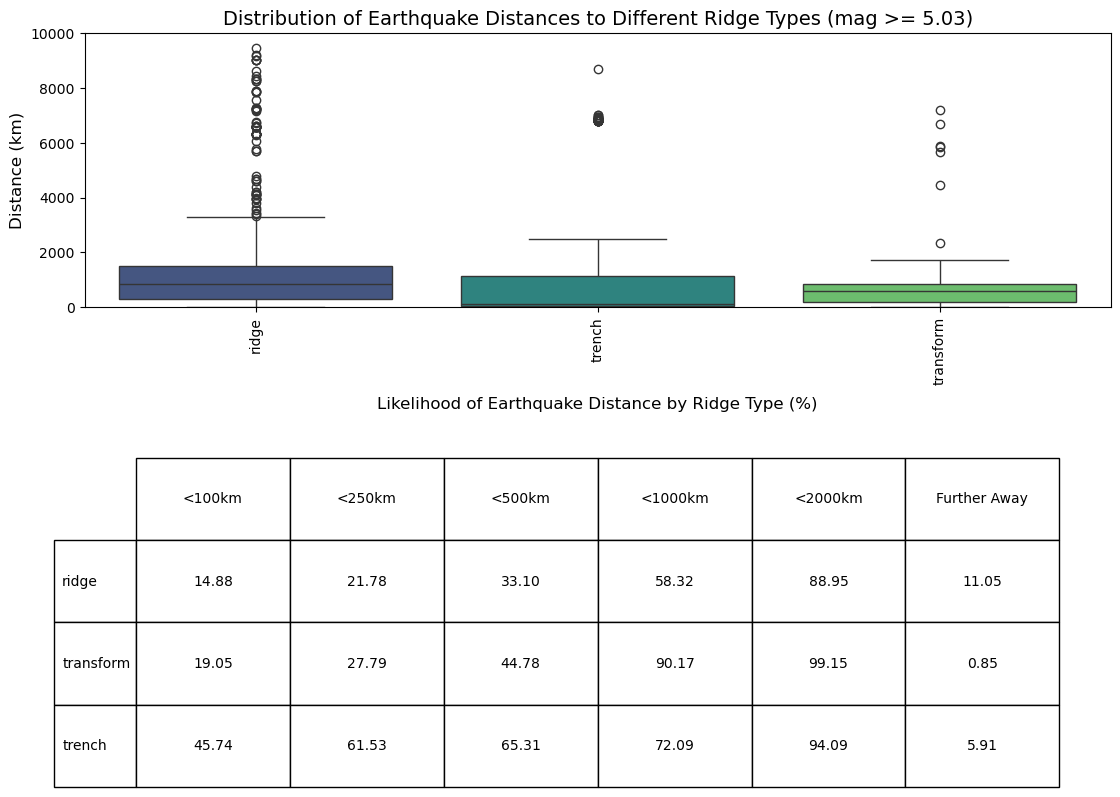

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For example data

## --- Make sure calculate_ridge_distance_likelihood is defined as before ---
def calculate_ridge_distance_likelihood(df, distance_column='distance_to_plate_km', boundary_type_column='nearest_plate_boundary_t', distance_thresholds=[100, 250, 500, 1000, 2000]):
    """
    Calculates the likelihood (percentage) of earthquakes occurring within specified distance thresholds for each ridge type. Handles empty input DataFrame.
    (Function content remains the same as the robust version from previous steps)
    """
    if df.empty:
        cols = [f"<{th}km" for th in distance_thresholds] + ["Further Away"]
        return pd.DataFrame(columns=cols)
    df_calc = df.copy(); df_calc = df_calc.dropna(subset=[distance_column, boundary_type_column])
    if df_calc.empty:
        cols = [f"<{th}km" for th in distance_thresholds] + ["Further Away"]; return pd.DataFrame(columns=cols)
    ridge_types = df_calc[boundary_type_column].unique()
    if len(ridge_types) == 0:
         cols = [f"<{th}km" for th in distance_thresholds] + ["Further Away"]; return pd.DataFrame(columns=cols)
    results = {}
    for ridge_type in ridge_types:
        ridge_data = df_calc[df_calc[boundary_type_column] == ridge_type][distance_column]; total_count = len(ridge_data)
        results[ridge_type] = {}
        if total_count == 0:
            likelihood_further = 0.0; results[ridge_type] = {f"<{threshold}km": 0.0 for threshold in distance_thresholds}
        else:
            for threshold in distance_thresholds: results[ridge_type][f"<{threshold}km"] = (len(ridge_data[ridge_data <= threshold]) / total_count) * 100
            likelihood_further = (len(ridge_data[ridge_data > distance_thresholds[-1]]) / total_count) * 100
        results[ridge_type]["Further Away"] = likelihood_further
    results_df = pd.DataFrame(results).T; results_df = results_df.sort_index(); results_df.index.name = "Ridge Type"
    expected_cols = [f"<{th}km" for th in distance_thresholds] + ["Further Away"]
    for col in expected_cols:
        if col not in results_df.columns: results_df[col] = 0.0
    results_df = results_df[expected_cols]
    return results_df

def visualize_ridge_distance_likelihood_combined(
    df, distance_column='distance_to_plate',
    boundary_type_column='nearest_plate_boundary_t',
    max_distance=10000, 
    minmag=None, 
    mag_column='mag',
    distance_thresholds=[100, 250, 500, 1000, 2000],
    color_by=None # <-- New optional parameter
):
    """
    Visualizes earthquake distances (boxplot) and likelihoods (table).
    Adjusts layout for many categories, rotates labels, increases table spacing.
    Optionally colors boxplot by 'color_by' column and adds a legend.

    Args:
        df (pd.DataFrame): DataFrame with earthquake data.
        distance_column (str): Column name for distance (km).
        boundary_type_column (str): Column name for boundary type (x-axis).
        max_distance (int): Max distance for y-axis.
        minmag (float, optional): Minimum magnitude filter. Defaults to None.
        mag_column (str): Column name for magnitude. Defaults to 'mag'.
        distance_thresholds (list): Distance thresholds for likelihood calculation.
        color_by (str, optional): Column name to use for coloring the boxplot
                                   (hue). If None, color maps to x-axis category.
                                   Defaults to None.
    """

    orig_minmag = minmag

    # --- Data Preparation and Filtering ---
    df_filtered = df.copy()
    required_cols = [distance_column, boundary_type_column, mag_column]
    if color_by and color_by not in required_cols:
         required_cols.append(color_by) # Ensure color_by column is checked for NaNs

    df_filtered = df_filtered.dropna(subset=required_cols)

    if minmag is not None:
        df_filtered = df_filtered[df_filtered[mag_column] >= minmag]
        actual_minmag_used = minmag
    else:
        if df_filtered.empty:
             print("Warning: DataFrame empty after NaN drop.")
             return
        actual_minmag_used = df_filtered[mag_column].min()

    df_filtered = df_filtered[df_filtered[distance_column] <= max_distance]

    if df_filtered.empty:
        filter_mag_str = f"minmag={orig_minmag:.2f}" if orig_minmag is not None else "no minmag filter"
        print(f"Warning: No data left after filtering ({filter_mag_str}, max_distance={max_distance}).")
        return

    # --- Validate color_by column ---
    use_hue = False
    if color_by:
        if color_by in df_filtered.columns:
            use_hue = True
            print(f"Coloring boxplot by column: '{color_by}'")
        else:
            print(f"Warning: 'color_by' column '{color_by}' not found in filtered data. Ignoring.")
            color_by = None # Reset to None if invalid


    # --- Calculate Likelihoods ---
    results_df = calculate_ridge_distance_likelihood(df_filtered, distance_column, boundary_type_column, distance_thresholds)

    # --- Plotting Setup ---
    num_categories = len(df_filtered[boundary_type_column].unique())
    base_fig_width = 8
    # --- MODIFICATION: Increase width per category slightly ---
    width_per_category = 0.55 # OLD: 0.4 or 0.5. NEW: Try 0.55
    min_fig_width = 12
    fig_width = max(min_fig_width, base_fig_width + num_categories * width_per_category)
    fig_height = 13

    fig, axes = plt.subplots(
        2, 1,
        figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios': [2, 3]} # Keep table area larger
    )

    # --- Boxplot (Top Axes) ---
    plot_kwargs = {
        'x': boundary_type_column,
        'y': distance_column,
        'data': df_filtered,
        'ax': axes[0]
    }
    if use_hue:
        plot_kwargs['hue'] = color_by
        plot_kwargs['palette'] = 'Set2' # Use a categorical palette for hue
    else:
        plot_kwargs['palette'] = 'viridis' # Keep original behavior if no hue

    sns.boxplot(**plot_kwargs)

    title_minmag_str = f"{actual_minmag_used:.2f}"
    axes[0].set_title(f"Distribution of Earthquake Distances to Different Ridge Types (mag >= {title_minmag_str})", fontsize=14)
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Distance (km)", fontsize=12)
    axes[0].set_ylim(0, max_distance)
    axes[0].tick_params(axis='x', rotation=90)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

    # --- Add Legend if using hue ---
    if use_hue:
        # Place legend outside the top right corner of the plot
        axes[0].legend(title=color_by, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
        # Adjust right margin to make space for the legend
        right_margin = 0.85 # Shrink plot area to 85% to fit legend
    else:
        # Use more of the figure width if no legend
        right_margin = 0.98

    # --- Table (Bottom Axes) ---
    axes[1].axis('off')
    if results_df.empty:
        print("Warning: Likelihood calculation resulted in empty data. Skipping table.")
        axes[1].text(0.5, 0.5, "No likelihood data to display.", ha='center', va='center', fontsize=12)
    else:
        formatted_results_df = results_df.applymap(lambda x: f"{x:.2f}")
        axes[1].text(0.5, 0.95,
                     "Likelihood of Earthquake Distance by Ridge Type (%)",
                     ha='center', va='top', fontsize=12, transform=axes[1].transAxes)
        table_bbox = [0.05, 0.0, 0.9, 0.80]
        table = axes[1].table(cellText=formatted_results_df.values,
                              colLabels=formatted_results_df.columns,
                              rowLabels=formatted_results_df.index,
                              loc='center', cellLoc='center', bbox=table_bbox)
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 2.4) # Keep generous row spacing

    # --- Final Layout Adjustments ---
    # Adjust bottom margin for labels AND right margin for potential legend
    plt.subplots_adjust(bottom=0.30, right=right_margin)
    # Alternatively, use tight_layout with rect, which might handle margins better together
    # plt.tight_layout(rect=[0, 0.05, right_margin, 0.95]) # Adjust rect based on legend presence


    plt.show()

# Example usage (assuming 'earthquake_gdf_with_distances' DataFrame exists):
visualize_ridge_distance_likelihood_combined(earthquake_gdf_with_distances, distance_column='distance_to_plate_km', boundary_type_column='nearest_plate_boundary_t', distance_thresholds=[100, 250, 500, 1000, 2000])

In [23]:
import pandas as pd
from scipy import stats

def analyze_ridge_likelihood_difference(df, distance_column='distance_to_plate_km', boundary_type_column='nearest_plate_boundary_t', distance_threshold=100, ridge_type=None):
    """
    Analyzes if there is a statistically significant difference in the likelihood of earthquakes occurring within a certain distance
    of a specific ridge type compared to other ridge types.

    Args:
        df (pd.DataFrame): The DataFrame containing earthquake data and ridge information.
        distance_column (str): The name of the column containing the distance to the plate boundary (in km).
        boundary_type_column (str): The name of the column indicating the type of plate boundary.
        distance_threshold (int): The distance threshold (in km) to analyze.
        ridge_type (str, optional): The specific ridge type to compare against others. If None, the function iterates through
                                      each ridge type, comparing it against all others.

    Returns:
       dict: A dictionary of dictionaries. The outer dictionary is keyed by ridge_type.
              The inner dictionary contains the following keys:
                  - 'compared_to' (str): Ridge type being compared against.
                  - 'statistic' (float): The Mann-Whitney U statistic.
                  - 'pvalue' (float): The p-value from the Mann-Whitney U test.
                  - 'interpretation' (str): Interpretation of the statistical significance.
    """

    df = df.copy()
    df = df.dropna(subset=[distance_column, boundary_type_column])

    results = {}  # Store results for each ridge type

    # Get unique ridge types
    ridge_types = df[boundary_type_column].unique()


    if ridge_type is None: #Iterate over Ridge Types
        ridge_types_to_analyze = ridge_types
    else: # analyze one ridge type at a time
        ridge_types_to_analyze = [ridge_type]

    for ridge_type_to_analyze in ridge_types_to_analyze:

        results[ridge_type_to_analyze] = {} #Initialize dictionary

        for other_ridge_type in ridge_types: #Compare one at a time

            if ridge_type_to_analyze == other_ridge_type:
                continue #skip self

            results[ridge_type_to_analyze][other_ridge_type] = {} #Initialize the dictionary

            # Create binary variable for earthquakes within the specified distance of the current ridge type.
            is_ridge = (df[boundary_type_column] == ridge_type_to_analyze)
            is_within_threshold = (df[distance_column] <= distance_threshold)

            #Here's where you went wrong -- the groups were being compared ONLY with them, not with ALL data points for each ridge type
            ridge_group = is_within_threshold[is_ridge] #Only where it IS that ridge type and if it's W/IN distance
            other_group = is_within_threshold[df[boundary_type_column] == other_ridge_type] #

            if len(ridge_group) == 0 or len(other_group) == 0:
                results[ridge_type_to_analyze][other_ridge_type]['compared_to'] = other_ridge_type
                results[ridge_type_to_analyze][other_ridge_type]['statistic'] = None
                results[ridge_type_to_analyze][other_ridge_type]['pvalue'] = None
                results[ridge_type_to_analyze][other_ridge_type]['interpretation'] = "Insufficient data"
                continue  # Skip the test if either group is empty

            # Perform Mann-Whitney U test
            try:
                u_statistic, p_value = stats.mannwhitneyu(ridge_group, other_group, alternative='greater')
            except ValueError as e:
                results[ridge_type_to_analyze][other_ridge_type]['compared_to'] = other_ridge_type
                results[ridge_type_to_analyze][other_ridge_type]['statistic'] = None
                results[ridge_type_to_analyze][other_ridge_type]['pvalue'] = None
                results[ridge_type_to_analyze][other_ridge_type]['interpretation'] = f"Error performing test: {e}"
                continue

            # Interpretation based on p-value
            alpha = 0.05
            if p_value < alpha:
                results[ridge_type_to_analyze][other_ridge_type]['compared_to'] = other_ridge_type
                results[ridge_type_to_analyze][other_ridge_type]['statistic'] = u_statistic
                results[ridge_type_to_analyze][other_ridge_type]['pvalue'] = p_value
                results[ridge_type_to_analyze][other_ridge_type]['interpretation'] = f"Earthquakes are significantly more likely to occur within {distance_threshold}km of {ridge_type_to_analyze} compared to {other_ridge_type}."
            else:
                results[ridge_type_to_analyze][other_ridge_type]['compared_to'] = other_ridge_type
                results[ridge_type_to_analyze][other_ridge_type]['statistic'] = u_statistic
                results[ridge_type_to_analyze][other_ridge_type]['pvalue'] = p_value
                results[ridge_type_to_analyze][other_ridge_type]['interpretation'] = f"There is no significant difference in the likelihood of earthquakes occurring within {distance_threshold}km of {ridge_type_to_analyze} compared to {other_ridge_type}."

    return results

# Example Usage
results = analyze_ridge_likelihood_difference(earthquake_gdf_with_distances, distance_threshold=100) #Analyze with distance threshold as 100
for ridge_type, comparisons in results.items():
    print(f"Results for {ridge_type}:")
    for other_ridge, data in comparisons.items():
        print(f"  Compared to {other_ridge}:")
        print(f"    Statistic: {data.get('statistic')}")
        print(f"    P-value: {data.get('pvalue')}")
        print(f"    Interpretation: {data['interpretation']}")

Results for ridge:
  Compared to trench:
    Statistic: 911200.0
    P-value: 1.0
    Interpretation: There is no significant difference in the likelihood of earthquakes occurring within 100km of ridge compared to trench.
  Compared to transform:
    Statistic: 1008319.0
    P-value: 0.9978099815588543
    Interpretation: There is no significant difference in the likelihood of earthquakes occurring within 100km of ridge compared to transform.
Results for trench:
  Compared to ridge:
    Statistic: 1724528.0
    P-value: 2.6967777115443077e-86
    Interpretation: Earthquakes are significantly more likely to occur within 100km of trench compared to ridge.
  Compared to transform:
    Statistic: 538636.0
    P-value: 8.26566276307997e-34
    Interpretation: Earthquakes are significantly more likely to occur within 100km of trench compared to transform.
Results for transform:
  Compared to ridge:
    Statistic: 1096177.0
    P-value: 0.0021904650223039707
    Interpretation: Earthquakes ar

Based on the provided results, we can make the following statements about the likelihood of earthquakes occurring within 100km of different ridge types:

*   **Trenches vs. Other Ridge Types:** Earthquakes are significantly more likely to occur within 100km of trenches compared to both ridges and transform faults. This suggests that trenches are a more seismically active environment in close proximity (within 100km) than the other two.
*   **Transform Faults vs. Ridges:** Earthquakes are significantly more likely to occur within 100km of transform faults compared to ridges. This suggests that transform faults also represent a more seismically active setting within 100km than ridges.
*   **Ridges vs. All Others:** There is *no* statistically significant difference in earthquake likelihood between ridges and either trenches or transform faults. This suggests that ridges, at least within 100km, are the *least* likely of these three plate boundary types to have nearby earthquakes.
*   **Transform Faults vs Trenches:** Earthquakes are not significantly different between transform faults and trenches.

**In summary,** these findings suggest a hierarchy in terms of the likelihood of earthquakes occurring within 100km of these plate boundary types:

**Trenches > Transform Faults > Ridges.**

Specifically, we can say:

1.  Earthquakes are generally more concentrated near trenches within a 100km radius compared to the others.
2.  Earthquakes are more common near transform faults compared to ridges within 100km, but the difference is not always significant compared to trenches.
3.  Ridge plate boundaries are less likely than trench plate boundaries to have earthquakes within 100km. The liklihood of them having earthquakes is similar to transform faults.

In [24]:
# Example Usage
results = analyze_ridge_likelihood_difference(earthquake_gdf_with_distances, distance_threshold=1000) #Analyze with distance threshold as 100
for ridge_type, comparisons in results.items():
    print(f"Results for {ridge_type}:")
    for other_ridge, data in comparisons.items():
        print(f"  Compared to {other_ridge}:")
        print(f"    Statistic: {data.get('statistic')}")
        print(f"    P-value: {data.get('pvalue')}")
        print(f"    Interpretation: {data['interpretation']}")

Results for ridge:
  Compared to trench:
    Statistic: 1136100.0
    P-value: 0.9999999999999939
    Interpretation: There is no significant difference in the likelihood of earthquakes occurring within 1000km of ridge compared to trench.
  Compared to transform:
    Statistic: 716905.0
    P-value: 1.0
    Interpretation: There is no significant difference in the likelihood of earthquakes occurring within 1000km of ridge compared to transform.
Results for trench:
  Compared to ridge:
    Statistic: 1499628.0
    P-value: 6.132427173908115e-15
    Interpretation: Earthquakes are significantly more likely to occur within 1000km of trench compared to ridge.
  Compared to transform:
    Statistic: 348324.0
    P-value: 1.0
    Interpretation: There is no significant difference in the likelihood of earthquakes occurring within 1000km of trench compared to transform.
Results for transform:
  Compared to ridge:
    Statistic: 1387591.0
    P-value: 1.2513362616112227e-63
    Interpretation: 

Based on the provided results for a 1000km radius, we can make the following statements about the likelihood of earthquakes occurring within 1000km of different ridge types:

*   **Trenches vs. Ridges:** Earthquakes are significantly more likely to occur within 1000km of trenches compared to ridges. This remains consistent with the 100km analysis and reinforces the idea that trenches are associated with higher seismic activity over a broader area.
*   **Transform Faults vs. Ridges:** Earthquakes are significantly more likely to occur within 1000km of transform faults compared to ridges. This also remains consistent with the 100km analysis, suggesting that transform faults have more widespread seismic activity compared to ridges.
*   **Trenches vs. Transform Faults:** There is *no* statistically significant difference in earthquake likelihood between trenches and transform faults within 1000km.  This is a key difference from the 100km analysis.
*   **Ridges vs. All Others:** There is *no* statistically significant difference in earthquake likelihood between ridges and either trenches or transform faults.

**In summary,** these findings suggest a different hierarchy in terms of the likelihood of earthquakes occurring within 1000km of these plate boundary types:

**Trenches ≈ Transform Faults > Ridges.**

Specifically, we can say:

1.  Earthquakes are generally more concentrated near both trenches and transform faults within a 1000km radius compared to ridges.
2.  Trench plate boundaries are more likely than ridge plate boundaries to have earthquakes within 1000km.
3.  Transform fault plate boundaries are more likely than ridge plate boundaries to have earthquakes within 1000km.

The key differences between the 100km and 1000km analyses are:

*   **Trenches and Transform Faults:** At 100km, trenches were significantly more likely to have nearby earthquakes than transform faults. At 1000km, this difference disappears, and the likelihood of earthquakes is similar for both. This suggests that the influence of trenches on earthquake occurrence extends further out but isn't necessarily more intense very close to the boundary compared to transform faults.
*   **Overall Hierarchy:** At 100km, the hierarchy was Trenches > Transform Faults > Ridges. At 1000km, the hierarchy shifts to Trenches ≈ Transform Faults > Ridges. The distinction between trenches and transform faults becomes less clear at the larger distance.
* **Interpretation:** At 1000km, the influence of a ridge plate boundary on how likely earthquakes are to occur significantly diminishes relative to other plates.

In [25]:
import pandas as pd
from scipy import stats

def analyze_mag_distance_correlation_by_boundary(df, mag_column='mag', distance_column='distance_to_plate_km', boundary_type_column='nearest_plate_boundary_t'):
    """
    Calculates the Spearman rank correlation between magnitude and distance
    separately for each plate boundary type.

    Args:
        df (pd.DataFrame): The DataFrame containing earthquake data.
        mag_column (str): Name of the magnitude column.
        distance_column (str): Name of the distance (in km) column.
        boundary_type_column (str): Name of the boundary type column.

    Returns:
        dict: A dictionary where keys are boundary types and values are
              dictionaries containing 'correlation' (Spearman's rho),
              'p_value', and 'interpretation'.
              Returns None for boundary types with insufficient data.
    """

    # Drop rows with NaN in relevant columns to avoid errors
    df_clean = df.dropna(subset=[mag_column, distance_column, boundary_type_column]).copy()

    boundary_types = df_clean[boundary_type_column].unique()
    results = {}
    alpha = 0.05  # Significance level

    for b_type in boundary_types:
        subset = df_clean[df_clean[boundary_type_column] == b_type]

        # Need at least 3 data points for a meaningful correlation calculation
        if len(subset) < 3:
            results[b_type] = {
                'correlation': None,
                'p_value': None,
                'interpretation': f"Insufficient data points ({len(subset)}) for correlation."
            }
            continue

        # Calculate Spearman correlation and p-value
        try:
            correlation, p_value = stats.spearmanr(subset[mag_column], subset[distance_column])

            # Interpret the result
            interpretation = f"Spearman Correlation (rho): {correlation:.3f}, P-value: {p_value:.3g}. "
            if p_value < alpha:
                if correlation > 0.1: # Threshold for weak positive correlation
                    interpretation += f"There is a statistically significant weak-to-moderate positive correlation: higher magnitude earthquakes tend to occur slightly further from the {b_type} boundary."
                elif correlation < -0.1: # Threshold for weak negative correlation
                    interpretation += f"There is a statistically significant weak-to-moderate negative correlation: higher magnitude earthquakes tend to occur slightly closer to the {b_type} boundary."
                else:
                     interpretation += f"There is a statistically significant but very weak correlation (close to zero), suggesting little practical relationship."

            else:
                interpretation += f"There is no statistically significant correlation between magnitude and distance for the {b_type} boundary."

            results[b_type] = {
                'correlation': correlation,
                'p_value': p_value,
                'interpretation': interpretation
            }
        except Exception as e: # Catch potential errors during calculation
             results[b_type] = {
                'correlation': None,
                'p_value': None,
                'interpretation': f"Error during correlation calculation: {e}"
            }


    return results

# --- Example Usage ---
# Assuming 'earthquake_gdf_with_distances' is your DataFrame and
# 'distance_to_plate_km' column exists.

correlation_results = analyze_mag_distance_correlation_by_boundary(earthquake_gdf_with_distances)

# Print the results clearly
print("Correlation between Magnitude and Distance by Boundary Type:\n")
for boundary_type, result in correlation_results.items():
    print(f"--- {boundary_type} ---")
    if result['correlation'] is not None:
        print(f"  Spearman's rho: {result['correlation']:.3f}")
        print(f"  P-value: {result['p_value']:.3g}") # Use general format for p-value display
        print(f"  Interpretation: {result['interpretation']}")
    else:
        print(f"  {result['interpretation']}") # Print error or insufficient data message
    print("-" * (len(boundary_type) + 8) + "\n")

Correlation between Magnitude and Distance by Boundary Type:

--- ridge ---
  Spearman's rho: 0.002
  P-value: 0.915
  Interpretation: Spearman Correlation (rho): 0.002, P-value: 0.915. There is no statistically significant correlation between magnitude and distance for the ridge boundary.
-------------

--- trench ---
  Spearman's rho: 0.059
  P-value: 0.0585
  Interpretation: Spearman Correlation (rho): 0.059, P-value: 0.0585. There is no statistically significant correlation between magnitude and distance for the trench boundary.
--------------

--- transform ---
  Spearman's rho: -0.012
  P-value: 0.74
  Interpretation: Spearman Correlation (rho): -0.012, P-value: 0.74. There is no statistically significant correlation between magnitude and distance for the transform boundary.
-----------------



Based on the Spearman correlation analysis results:

*   **Overall Finding:** The dataset **does not show a significant simple monotonic relationship** (either consistently increasing or decreasing) between earthquake magnitude and the distance to the plate boundary for *any* of the three types analysed (ridge, trench, transform).

*   **Ridge Boundary:**
    *   Spearman's rho: 0.002 (, those results **absolutely make sense** statistically, and they tell a consistent story:

1.  **Ridge (rho = 0.002, p = 0.915):**
    *   The correlation coefficient (rho) is extremely close to zero, indicating practically no monotonic relationship in your sample data.
    *   The p-value is very high (much greater than the typical 0.05 threshold). This means you cannot reject the null hypothesis (that there is no correlation).
    *   **Conclusion:** Your data provides no statistically significant evidence that earthquake magnitude is related (either positively or negatively) to the distance from a ridge boundary.

2.  **Trench (rho = 0.059, p = 0.0585):**
    *   The correlation coefficient (rho) is still very small, suggesting only a very weak positive tendency in the sample (larger quakes slightly further away).
    *   The p-value is *just* above the conventional 0.05 significance level.
    *   **Conclusion:** Strictly speaking, using alpha = 0.05, this result is *not statistically significant*. You fail to reject the null hypothesis. While the p-value is borderline, the correlation itself is so weak that even if it *were* significant, it would likely indicate a negligible practical relationship. There's no strong evidence here for a link between magnitude and distance near trenches.

3.  **Transform (rho = -0.012, p = 0.74):**
    *   The correlation coefficient (rho) is extremely close to zero, indicating practically no monotonic relationship in your sample (a tiny negative tendency).
    *   The p-value is very high. You cannot reject the null hypothesis.
    *   **Conclusion:** Your data provides no statistically significant evidence that earthquake magnitude is related to the distance from a transform boundary.

**Overall Interpretation:**

Based on this Spearman correlation analysis, **your dataset does not show a significant simple monotonic relationship (either increasing or decreasing) between earthquake magnitude and the distance to the plate boundary for *any* of the three types (ridge, trench, transform).**

**Does this make sense geologically?**

It's plausible. While different boundary types have different mechanisms, the relationship between the magnitude of an earthquake and its precise location relative to the *surface trace* of the plate boundary might be complex and not simply monotonic:

*   Large earthquakes can occur directly on the main fault but also on subsidiaryExtremely close to zero, indicating virtually no monotonic trend in the sample).
    *   P-value: 0.915 (Very high, far exceeding the typical 0.05 significance threshold).
    *   **Conclusion:** There is **no statistically significant evidence** from this data to suggest that earthquake magnitude is related to the distance from a ridge boundary.

*   **Trench Boundary:**
    *   Spearman's rho: 0.059 (Very weak positive tendency in the sample).
    *   P-value: 0.0585 (Borderline, slightly above the conventional 0.05 significance level).
    *   **Conclusion:** Strictly using α = 0.05, this result is **not statistically significant**. Even if it were significant, the correlation is very weak, suggesting little practical relationship between magnitude and distance near trenches based on this analysis.

*   **Transform Boundary:**
    *   Spearman's rho: -0.012 (Extremely close to zero, indicating virtually no monotonic trend in the sample).
    *   P-value: 0.74 (Very high).
    *   **Conclusion:** There is **no statistically significant evidence** from this data to suggest that earthquake magnitude is related to the distance from a transform boundary.

**Geological Plausibility:**

*   These results are plausible. The relationship between earthquake magnitude and its precise location relative to the plate boundary's surface trace can be complex.
*   Factors like earthquake depth (especially for trenches), the presence of subsidiary faults, and complex stress patterns mean that the largest earthquakes don't necessarily occur systematically faults nearby.
*   For trenches, the depth of the earthquake along the subducting slab is often more critical than the surface distance to the trench axis, and large events can occur at various depths/distances.
*   Stress accumulation and release patterns might be complex, meaning the largest events don't necessarily happen right at the boundary or systematically further away.

So, yes, finding near-zero, non-significant correlations is a perfectly reasonable outcome for this type of analysis. It suggests that if a relationship exists, it's likely more complex than a simple "bigger quakes are always closer/further" trend captured by Spearman correlation, or that other factors are much more dominant.

# Distance From Nearest Plate Ridge and Magnitude Analysis and Exploration
***Reusing functions from above with different input column***

In [26]:
earthquake_gdf_with_distances.head()

,id,mag,place,time,felt,cdi,mmi,alert,status,tsunami,sig,net,code,nst,dmin,rms,gap,magType,type,geometry,source_date,utm_zone,utm_epsg,utm_geometry,distance_to_plate,nearest_plate_strnum,nearest_plate_platecode,nearest_plate_geogdesc,nearest_plate_boundary_t,distance_to_plate_km
104,us70006t8d,5.4,south of the Kermadec Islands,1577906930580,NaN,NaN,0.00,green,reviewed,0,449,us,70006t8d,NaN,3.721,0.97,49.0,mww,earthquake,POINT (-178.3339 -32.9622),2020-01-01,1S,EPSG:32701,POINT (375334.88133 6352113.91239),NaN,<NA>,<NA>,<NA>,<NA>,NaN
127,us70006t7e,5.1,"Near Islands, Aleutian Islands, Alaska",1577902211727,NaN,NaN,NaN,None,reviewed,1,400,us,70006t7e,NaN,2.323,0.63,78.0,mww,earthquake,POINT (170.3548 53.2522),2020-01-01,59N,EPSG:32659,POINT (456953.37822 5900520.50625),9.045895e+05,2,201,SOUTH ATLANTIC RIDGE,ridge,904.589534
332,us70006t3c,5.4,"207 km NE of Neiafu, Tonga",1577867484136,NaN,NaN,0.00,green,reviewed,0,449,us,70006t3c,NaN,2.947,1.44,40.0,mww,earthquake,POINT (-172.5044 -17.428),2020-01-01,2S,EPSG:32702,POINT (340219.54549 8072468.10184),NaN,<NA>,<NA>,<NA>,<NA>,NaN
499,us70006t13,5.1,"112 km SSE of Kokopo, Papua New Guinea",1577838500289,NaN,NaN,NaN,None,reviewed,0,400,us,70006t13,NaN,1.190,0.79,74.0,mb,earthquake,POINT (152.5514 -5.3245),2020-01-01,56S,EPSG:32756,POINT (450295.50701 9411447.72947),1.766909e+05,2,201,SOUTH ATLANTIC RIDGE,ridge,176.690903
624,us70006ttf,5.7,"38 km ENE of Hasaki, Japan",1577989433135,102.0,4.7,4.11,green,reviewed,0,548,us,70006ttf,NaN,0.912,1.03,61.0,mww,earthquake,POINT (141.249 35.8098),2020-01-02,54N,EPSG:32654,POINT (522495.56476 3962881.42853),1.599986e+06,2,201,SOUTH ATLANTIC RIDGE,ridge,1599.986203


C:\Users\Hannah Miller Young\AppData\Local\Temp\ipykernel_17184\2677506604.py:141: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


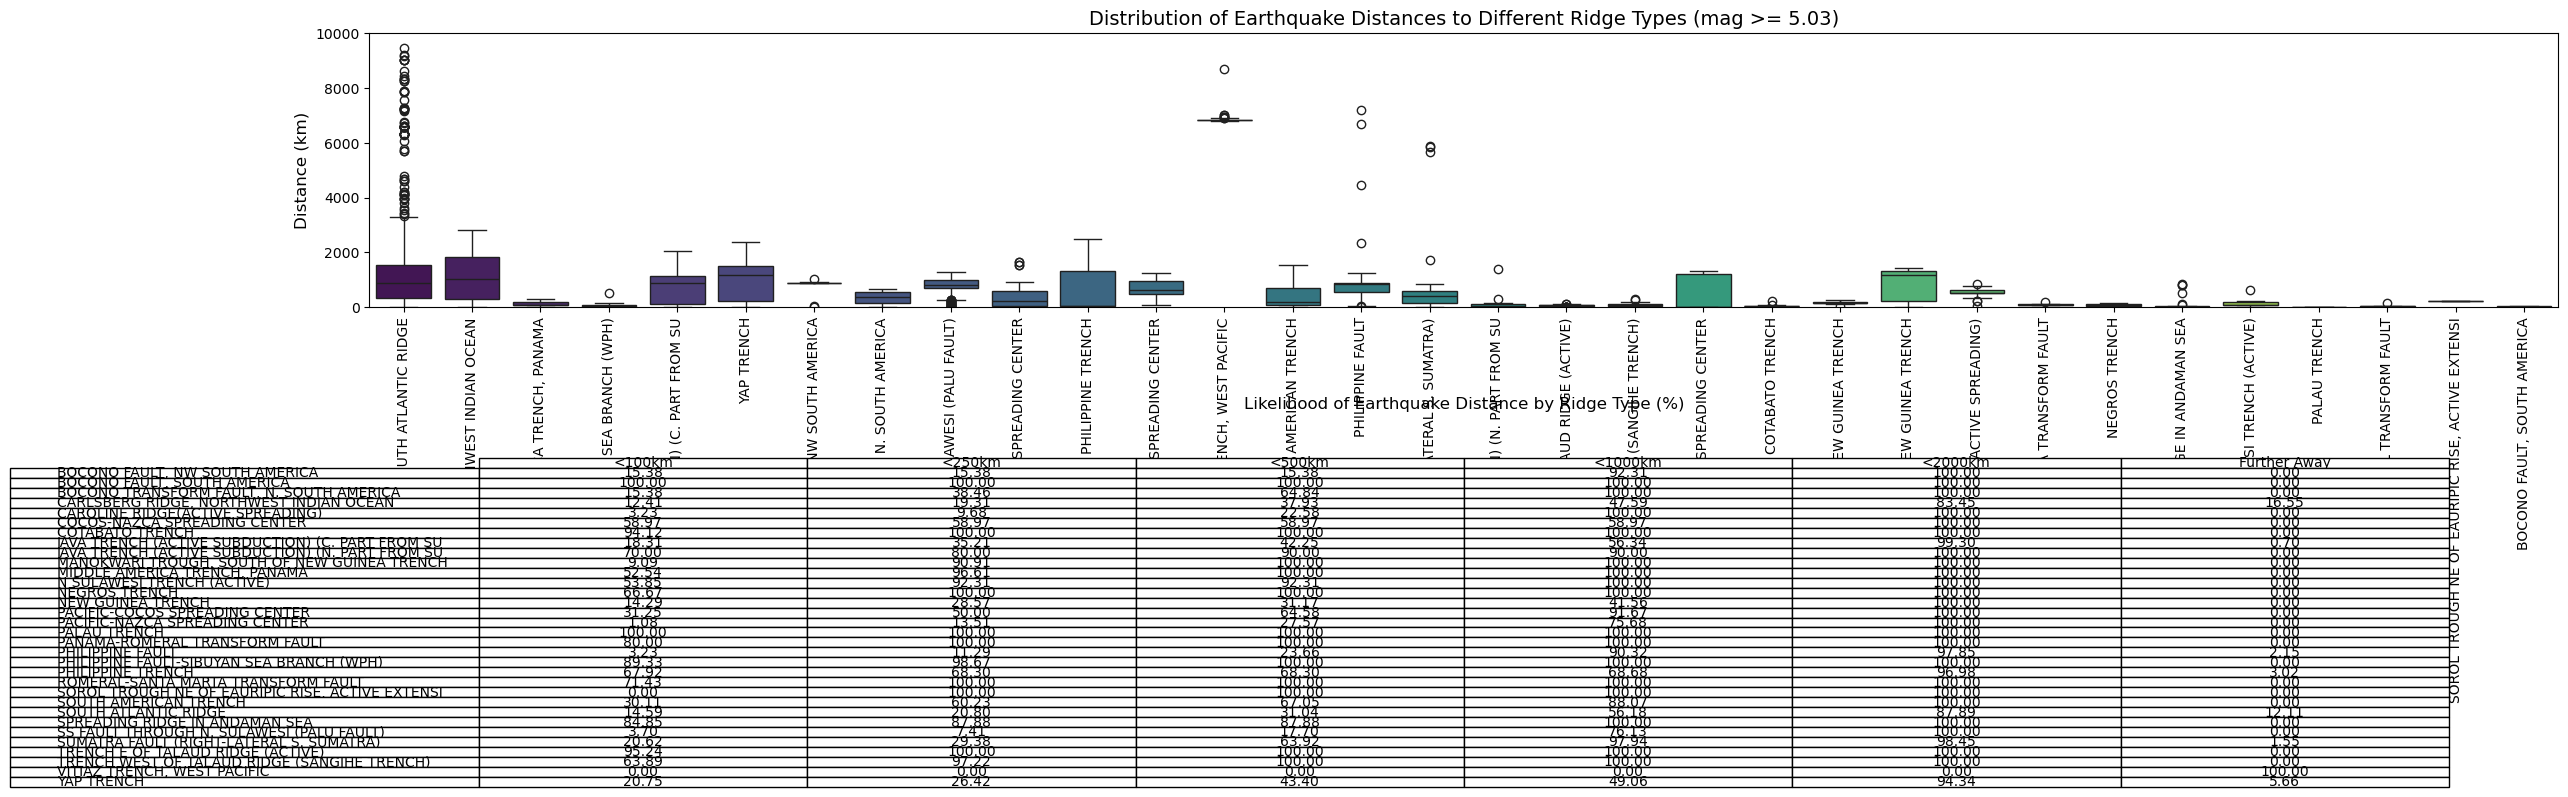

In [27]:
visualize_ridge_distance_likelihood_combined(earthquake_gdf_with_distances, distance_column='distance_to_plate_km', boundary_type_column='nearest_plate_geogdesc', distance_thresholds=[100, 250, 500, 1000, 2000])

Coloring boxplot by column: 'nearest_plate_boundary_t'


C:\Users\Hannah Miller Young\AppData\Local\Temp\ipykernel_17184\2677506604.py:141: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


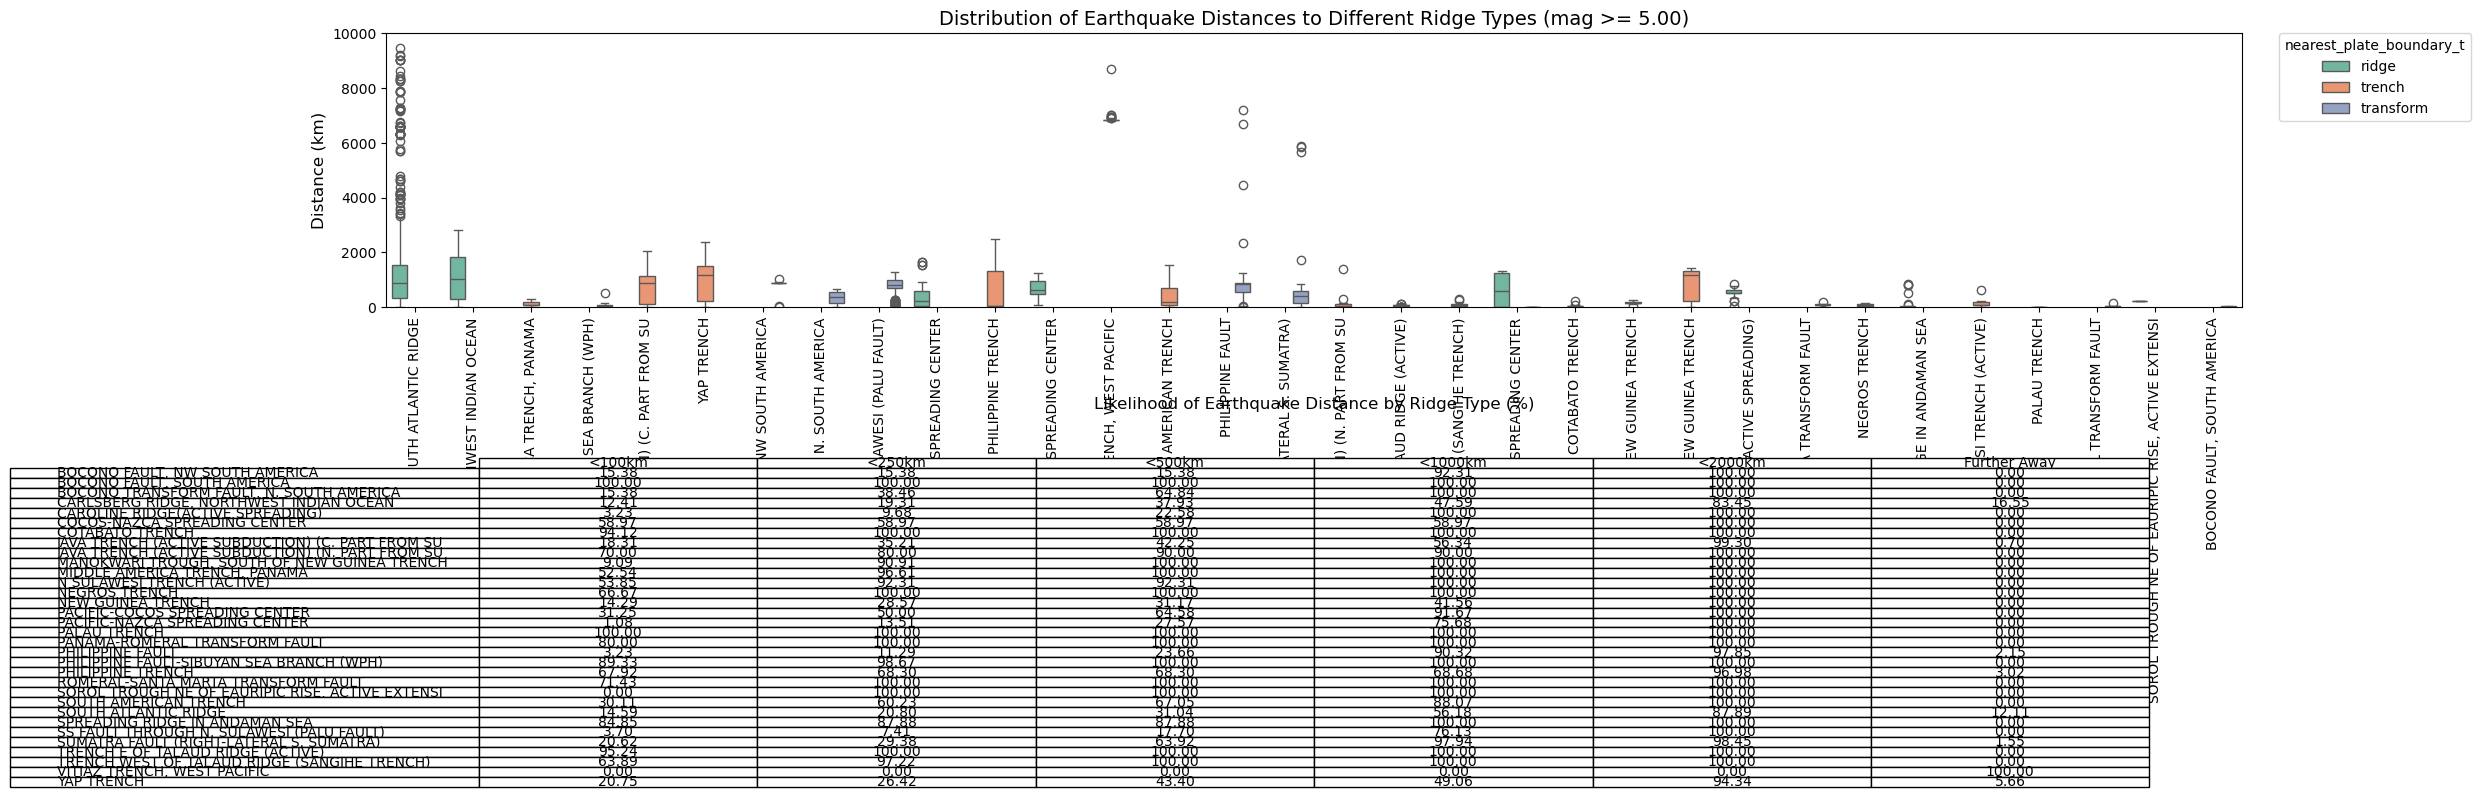

In [29]:
# Now call the function with the desired column
visualize_ridge_distance_likelihood_combined(
    earthquake_gdf_with_distances,
    distance_column='distance_to_plate_km',
    boundary_type_column='nearest_plate_geogdesc', # Use the alternative column
    distance_thresholds=[100, 250, 500, 1000, 2000],
    minmag=5.0,
    color_by='nearest_plate_boundary_t'
)